# Lets create an EDA class


### Refer to requirements.txt for library details


In [18]:
!pip3 install -r requirements.txt

In [21]:
!pip3 install --upgrade scalecast

In [19]:
import darts as dt
import pmdarima as pdm
import autotimeseries as ats  # << This is different from Auto_TS >>
import statsforecast as stf
import skforecast as skf
import scalecast as scl

In [20]:
df = pd.read_csv('a10.csv', parse_dates=['date'], index_col='date')
#df.head()
#df.reset_index(inplace=True)
# df['year'] = [d.year for d in df.date]
# df['month'] = [d.strftime('%b') for d in df.date]
# df['month'] = df.date.dt.month

df.head()

,date,value,month
0,1991-07-01,3.526591,7
1,1991-08-01,3.180891,8
2,1991-09-01,3.252221,9
3,1991-10-01,3.611003,10
4,1991-11-01,3.565869,11


# EDA class containing all the above functions

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.filters.bk_filter import bkfilter
from statsmodels.tsa.filters.hp_filter import hpfilter
import scalecast as sc
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from scalecast.Forecaster import Forecaster
from scipy.stats import boxcox
from scipy.stats import normaltest
from hurst import compute_Hc, random_walk
from scipy import signal
from pmdarima.arima import ndiffs
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.feature_selection import f_regression



class EDA:
    def __init__(self, data):
        self.data = data
        
        
    def print_summary(self):
        print("Data Summary:")
        print(self.data.head())
        print('\n')
        print(f"Number of observations: {len(self.data)}")
        print(f"Data type: {self.data.dtypes[0]}")
        print(f"Start date: {self.data.index[0]}")
        print(f"End date: {self.data.index[-1]}")
        print(f"Missing values: {self.data.isnull().sum().sum()}")
        
        
    def plot_time_series(self, title='Time Series Plot', xlabel='Time', ylabel='Value'):
        plt.figure(figsize=(10, 6))
        plt.plot(self.data)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    
    def plot_acf_pacf(self, lags=30):
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
        plot_acf(self.data, ax=ax[0], lags=lags)
        plot_pacf(self.data, ax=ax[1], lags=lags)
        plt.show()
    
    def plot_seasonal_decomposition(self, model='additive'):
        from statsmodels.tsa.seasonal import seasonal_decompose
        result = seasonal_decompose(self.data, model=model)
        fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))
        ax[0].set(title='Original Time Series', xlabel='Time', ylabel='Value')
        ax[1].set(title='Trend Component', xlabel='Time', ylabel='Value')
        ax[2].set(title='Seasonal Component', xlabel='Time', ylabel='Value')
        ax[3].set(title='Residual Component', xlabel='Time', ylabel='Value')
        ax[0].plot(self.data)
        ax[1].plot(result.trend)
        ax[2].plot(result.seasonal)
        ax[3].plot(result.resid)
        plt.tight_layout()
        plt.show()
        
    def apply_detrending(self,col):
        '''
        This function helps in detrending the time series using scipy's signal module
        
        '''
        result = signal.detrend(self.data[col])
        plt.title('Detrended Series', fontsize=14)
        plt.xlabel('length')
        plt.ylabel('value')
        plt.plot(result)
        return result
    
    def calculate_autocorrelation(self, lag):
        return self.data.autocorr(lag=lag)
    
    
    def calculate_partial_autocorrelation(self, lag):
        from statsmodels.tsa.stattools import pacf
        return pacf(self.data, nlags=lag)[-1]
    
    
    def plot_autocorrelation(self, lags=30):
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(self.data, lags=lags)
        plt.show()
        
    
    def calculate_seasonal_difference(self, period):
        return self.data.diff(period).dropna()
    
    
    def calculate_percentage_change(self):
        return self.data.pct_change().dropna()
    
    
    def rolling_mean(self, window):
        return self.data.rolling(window=window, min_periods=1).mean()
    
    
    def rolling_std(self, window):
        return self.data.rolling(window=window, min_periods=1).std()
    
    
    def plot_histogram(self):
        plt.hist(self.data, bins='auto')
        plt.title('Histogram')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.show()
    
    def plot_density(self):
        self.data.plot(kind='density')
        plt.title('Density Plot')
        plt.show()
    
    def plot_boxplot(self):
        plt.boxplot(self.data)
        plt.title('Box Plot')
        plt.xlabel('input')
        plt.ylabel('Value')
        plt.show()   
        
    
    def calculate_adf_test(self):
        """
        This function calculates the Augmented Dickey-Fuller (ADF) test and prints the results.
        This test is used to determine whether a time series is stationary or not. The null hypothesis of the test is 
        that the series has a unit root (i.e., it is non-stationary). If the p-value is less than a chosen significance 
        level (e.g., 0.05), then the null hypothesis is rejected and the series is considered stationary.
        
        """
        adf_test = adfuller(self.data, autolag='AIC')
        print("ADF test results:")
        print(f"ADF test statistic: {adf_test[0]}")
        print(f"p-value: {adf_test[1]}")
        print(f"Critical values: {adf_test[4]}")
    
    def calculate_kpss_test(self):
        """
        This function calculates the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test and prints the results.
        This test is another way to test for stationarity. The null hypothesis is that the series is stationary. If the 
        p-value is less than the chosen significance level, then the null hypothesis is rejected and the series is considered
        non-stationary.
                
        """
        kpss_test = kpss(self.data, regression='c')
        print("KPSS test results:")
        print(f"KPSS test statistic: {kpss_test[0]}")
        print(f"p-value: {kpss_test[1]}")
        print(f"Critical values: {kpss_test[3]}")
    
    def plot_lag_plot(self, lag=12):
        """
        This function plots the lag plot of the time series data
        """
        pd.plotting.lag_plot(self.data, lag=lag)
        plt.title('lag Plot')
        plt.show()
    
    def plot_loess_smoothing(self, col, frac=0.1):
        """
        This function plots the loess smoothing of the time series data
        """
        loess = sm.nonparametric.lowess(self.data[col], self.data.index.values, frac=frac)
        plt.plot(self.data.index.values, loess[:, 1], color='red',label = 'Smoothed')
        plt.plot(self.data.index.values, self.data, color='blue',label = 'Original')
        plt.title("Loess Smoothing")
        plt.legend()
        plt.show()
        
    def plot_lowess(self):
        """
        Plots the locally estimated scatterplot smoothing (LOESS) curve.
        """
        fig, ax = plt.subplots(figsize=(10, 5))
        sc.plot_lowess(self.data, ax=ax)
        plt.show()
        
    
    def plot_moving_average(self, window=3):
        """
        This function applies the moving average filter and plots the filtered data
        """
        rolling_mean = self.data.rolling(window=window).mean()
        plt.plot(self.data.index.values, rolling_mean, color='red',label = 'Rolling Mean')
        plt.plot(self.data.index.values, self.data, color='blue',label = 'Original')
        plt.legend()
        plt.show()
    
    def calculate_granger_causality(self, other_data, maxlag=4):
        """
        This test is used to determine whether one time series can be used to predict another time series. The null hypothesis
        is that the first series does not Granger-cause the second series. If the p-value is less than the chosen significance 
        level, then the null hypothesis is rejected and the first series is considered to Granger-cause the second series.
        
        """
        data = pd.concat([self.data, other_data], axis=1)
        granger_test = grangercausalitytests(data, maxlag=maxlag)
        for lag in range(1, maxlag+1):
            print(f"Lag {lag}")
            print(f"F-test: {granger_test[lag][0]['ssr_ftest'][0]}")
            print(f"p-value: {granger_test[lag][0]['ssr_ftest'][1]}")
    
    
    def apply_baxter_king_filter(self):
        '''
        The Baxter-King filter is a filter used to smooth a time series by removing high frequency fluctuations. It is 
        based on a bandpass filter that removes frequencies above a certain cutoff and below a certain low frequency. The 
        filter has two parameters: the cutoff frequency and the length of the filter. The cutoff frequency determines how 
        much high frequency noise to remove, and the length of the filter determines the smoothness of the resulting signal.
              
        '''
        cycle = bkfilter(self.data, low=6, high=32, K=12)
        plt.plot(self.data, label='Original')
        #plt.plot(trend, label='Trend')
        plt.plot(cycle, label='Cycle')
        plt.title('Baxter-King Filter')
        plt.legend()
        plt.show()

    def apply_hodrick_prescott_filter(self):
        
        '''
        The Hodrick-Prescott filter is a filter used to separate a time series into a trend component and a cyclical component.
        It is based on a quadratic penalty function that minimizes the sum of squared deviations of the cyclical component from
        the trend component. The filter has one parameter, the smoothing parameter, which determines the smoothness of the 
        resulting trend component.
        
        '''
        cycle, trend = hpfilter(self.data, lamb=1600)
        plt.plot(self.data, label='Original')
        plt.plot(trend, label='Trend')
        plt.plot(cycle, label='Cycle')
        plt.title('Hodrick-Prescott Filter')
        plt.legend()
        plt.show()
        
        
    def calculate_hurst_exponent(self):
        """
        Calculates the Hurst exponent for the time series data.
        The hurst exponent is a measure of the “long-term memory” of a time series. It can be used to determine whether 
        the time series is more, less, or equally likely to increase if it has increased in previous steps. 
        This property makes the Hurst exponent especially interesting for the analysis of stock data.

        Returns:
            The Hurst exponent.
        """
        H, _, _ = compute_Hc(self.data.values, kind='change', simplified=True)
        return H
    
    
    def calculate_ndiffs(self):
        ''' 
        This function uses ndiffs method from pdmarima and returns the estimated num of diffs
        '''
        kpss_diffs = ndiffs(self.data, alpha=0.05, test='kpss', max_d=6)
        adf_diffs = ndiffs(self.data, alpha=0.05, test='adf', max_d=6)
        n_diffs = max(adf_diffs, kpss_diffs)
        return ('Estimated number of diffs :' , n_diffs)
    
     
    def normality_test(self):
        '''
        This test is used to determine whether a time series is normally distributed or not. 
        
        '''        
        stat, p = normaltest(self.data)
        print(f"Normality Test Result: statistic={stat}, pvalue={p}")
        
        
    def ljung_box_test(self,col,lag=None):
        '''
        This test is used to determine whether a time series has significant autocorrelation at lags up to a certain value 
        (e.g., 10). The null hypothesis is that the series has no autocorrelation at those lags. If the p-value is less than
        the chosen significance level, then the null hypothesis is rejected and the series is considered to have significant 
        autocorrelation.
        
        Ideally, we would like to fail to reject the null hypothesis. That is, we would like to see the p-value of the test
        be greater than 0.05(say) because this means the residuals for our time series model are independent, which is often an 
        assumption we make when creating a model.
        
        Parameters
        
        lag = list of lags 
        col = dataframe column  
        
        return lb_stat and lb_pvalue
        
        '''
        return (acorr_ljungbox(self.data[col], lags=lag))
    
    
    def f_test(self, col, k=2):
        '''
        This test is used to select the k most significant features from a time series. The null hypothesis is that the 
        k features are not significant, i.e., the model with k features is not significantly better than the model with 
        all the features. The alternate hypothesis is that the k features are significant, i.e., the model with k features 
        is significantly better than the model with all the features.
        
         The f_test() method returns a list of the k most significant features. Note that this test assumes that the 
         residuals of the models are normally distributed and have constant variance, so it is important to check the 
         assumptions before using the test.
         
         Note - This function takes a timeIndexed input i.e. Set Date as the index column and then use this function
        
        
        '''
                
        X = np.arange(len(self.data)).reshape(-1, 1)
        y = self.data[col]
        f_values, p_values = f_regression(X, y)
        top_k = np.argsort(f_values)[::-1][:k]
        return self.data.columns[top_k], f_values[top_k], p_values[top_k]
         
    

In [83]:
df = pd.read_csv('a10.csv', parse_dates=['date'] , index_col='date')
df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [86]:
exp = EDA(df)

In [87]:
exp.f_test('value',2)

(Index(['value'], dtype='object'),
 array([1190.85215031]),
 array([1.22594642e-86]))

In [71]:
exp.ljung_box_test('value',[6,12])

,lb_stat,lb_pvalue
6,918.690676,3.419747e-195
12,1664.327467,0.000000e+00


In [35]:
exp

In [290]:
from statsmodels.tsa.filters.bk_filter import bkfilter
from statsmodels.tsa.filters.hp_filter import hpfilter

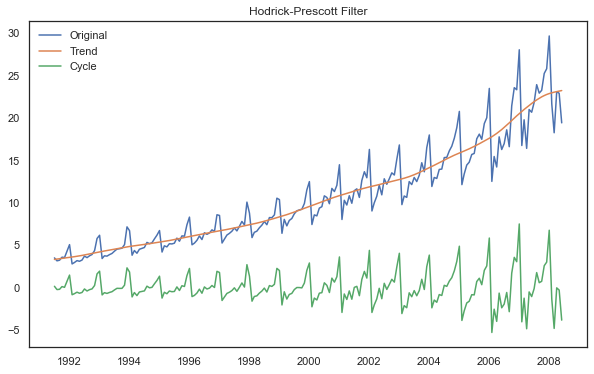

In [291]:
exp.apply_hodrick_prescott_filter()

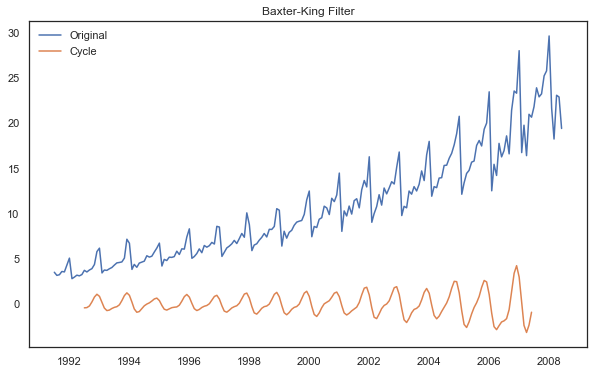

In [391]:
exp.apply_baxter_king_filter()

In [393]:
exp.calculate_granger_causality(df['value'])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=201, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=1264.3549, p=0.0000  , df_denom=201, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=199, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=716.2668, p=0.0000  , df_denom=199, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=197, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=478.3362, p=0.0000  , df_denom=197, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0000  , p=1.0000 

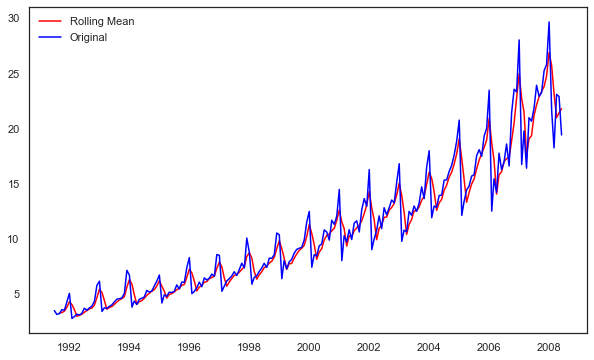

In [394]:
exp.plot_moving_average(3)

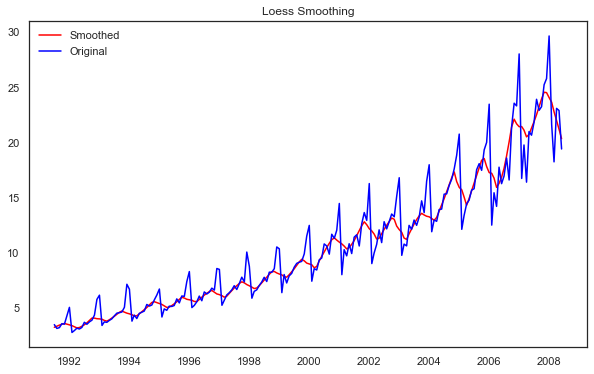

In [396]:
exp.plot_loess_smoothing('value',0.05)

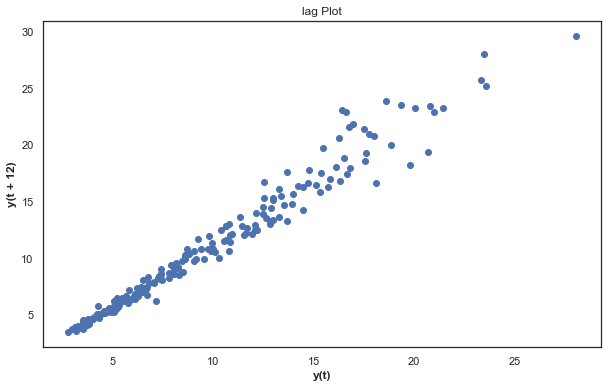

In [397]:
exp.plot_lag_plot(12)

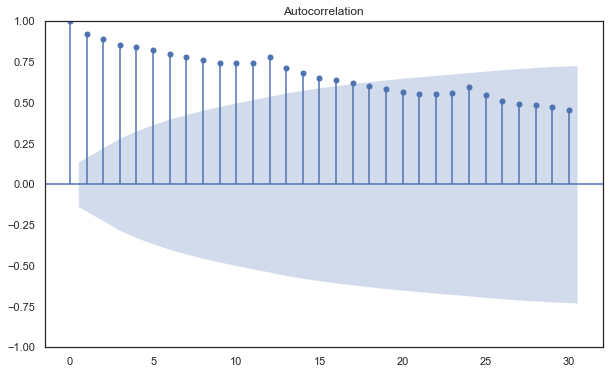

In [307]:
exp.plot_autocorrelation()

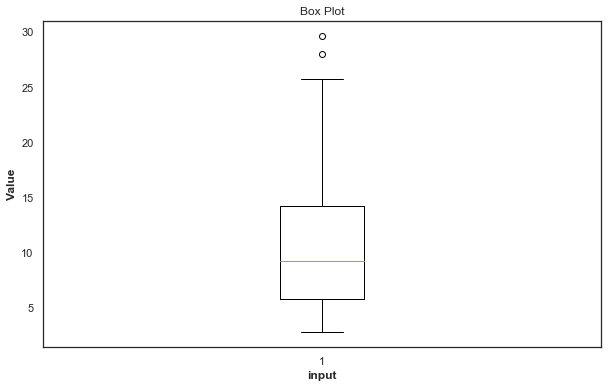

In [308]:
exp.plot_boxplot()

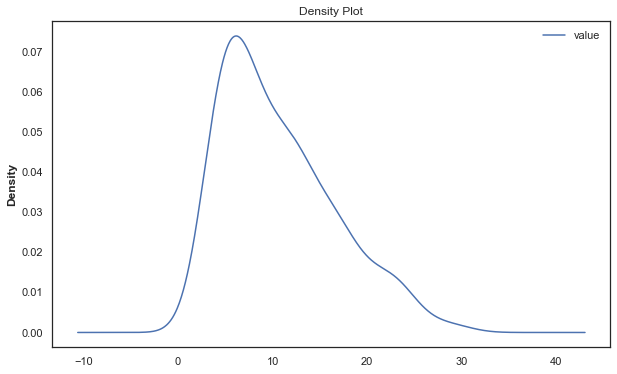

In [309]:
exp.plot_density()

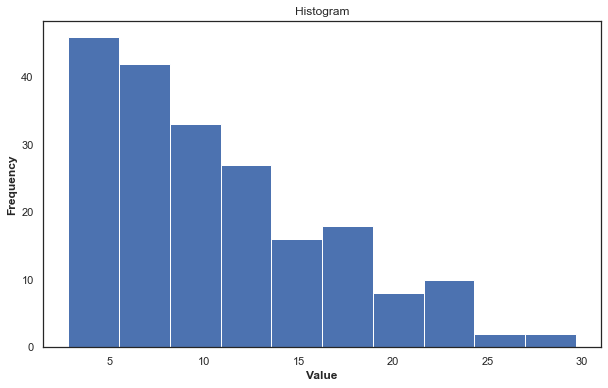

In [310]:
exp.plot_histogram()

In [311]:
exp.calculate_kpss_test()

KPSS test results:
KPSS test statistic: 2.0131256386303322
p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [312]:
exp.calculate_percentage_change()

,value
date,
1991-08-01,-0.098027
1991-09-01,0.022425
1991-10-01,0.110319
1991-11-01,-0.012499
1991-12-01,0.207664
...,...
2008-02-01,-0.270048
2008-03-01,-0.156521
2008-04-01,0.265138


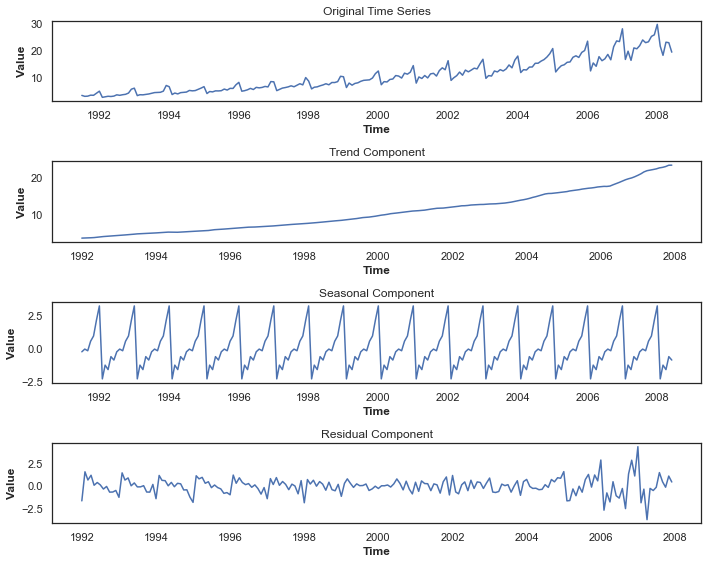

In [313]:
exp.plot_seasonal_decomposition(model='additive')

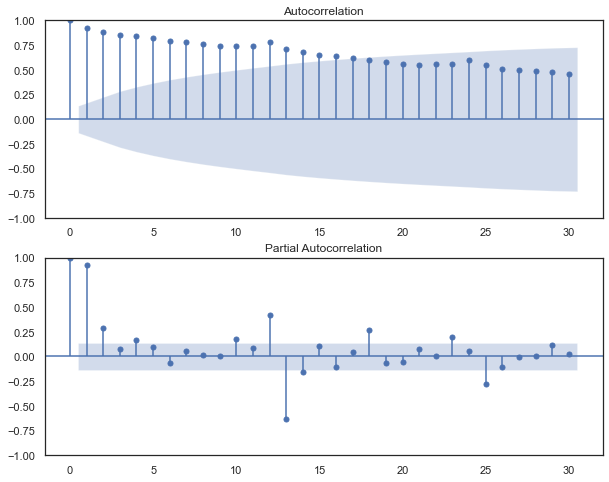

In [314]:
exp.plot_acf_pacf()

In [315]:
exp.calculate_seasonal_difference(12)

,value
date,
1992-07-01,0.211260
1992-08-01,0.377885
1992-09-01,0.524981
1992-10-01,0.313487
1992-11-01,0.820662
...,...
2008-02-01,4.890416
2008-03-01,-1.527809
2008-04-01,6.680372


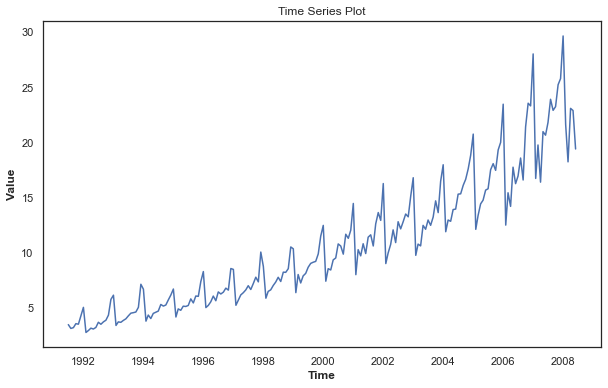

In [316]:
exp.plot_time_series()

In [317]:
x = pd.DataFrame(exp.log_transform())
type(x)
exp1 = EDA(x)

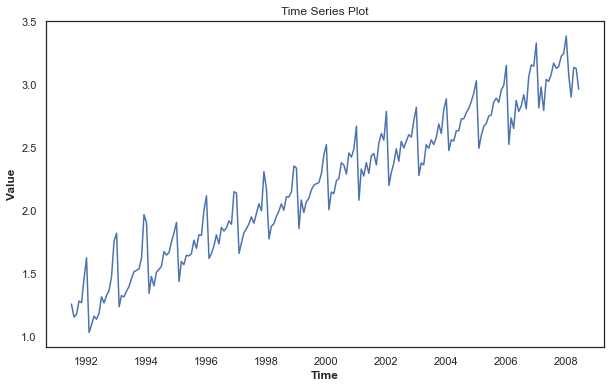

In [318]:
exp1.plot_time_series()

In [399]:
val1,lambd = exp.apply_boxcox_transformation('value')

In [400]:
lambd

0.061505584870954325

In [321]:
exp.calculate_hurst_exponent()

0.5695063064694355

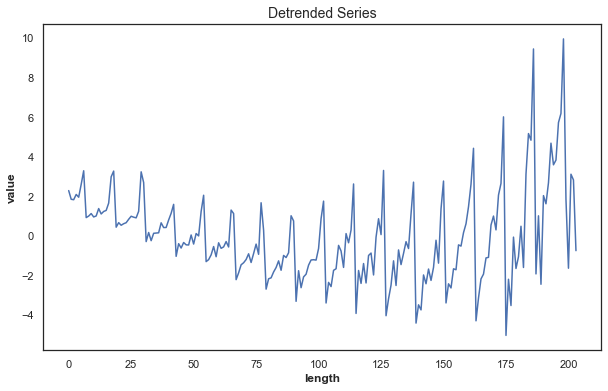

In [402]:
x1 = exp.apply_detrending('value')

In [323]:
exp.calculate_ndiffs()

('Estimated number of diffs :', 1)

In [351]:
exp.standardize_data()

array([[-1.20622366],
       [-1.26439901],
       [-1.2523954 ],
       [-1.19201857],
       [-1.19961385],
       [-1.07500013],
       [-0.94340907],
       [-1.32605293],
       [-1.29722761],
       [-1.2603789 ],
       [-1.27337066],
       [-1.24931548],
       [-1.17067227],
       [-1.20080746],
       [-1.16405019],
       [-1.13926404],
       [-1.06151059],
       [-0.82187287],
       [-0.75766988],
       [-1.21896838],
       [-1.16487391],
       [-1.17126932],
       [-1.14247681],
       [-1.11819559],
       [-1.07345285],
       [-1.03195112],
       [-1.02412976],
       [-1.01416922],
       [-0.94248242],
       [-0.59142427],
       [-0.66689726],
       [-1.15326733],
       [-1.06024096],
       [-1.11387854],
       [-1.03557587],
       [-1.0179112 ],
       [-0.99990638],
       [-0.8992736 ],
       [-0.9238681 ],
       [-0.90751161],
       [-0.82806686],
       [-0.75556201],
       [-0.66386636],
       [-1.09019667],
       [-0.96679794],
       [-0

In [352]:
exp.normalize_data()

array([[0.02651951],
       [0.01364468],
       [0.01630121],
       [0.02966325],
       [0.02798233],
       [0.05556069],
       [0.08468321],
       [0.        ],
       [0.00637935],
       [0.01453437],
       [0.01165915],
       [0.01698282],
       [0.03438741],
       [0.02771817],
       [0.03585295],
       [0.04133839],
       [0.05854607],
       [0.11158048],
       [0.12578929],
       [0.02369896],
       [0.03567065],
       [0.03425528],
       [0.04062737],
       [0.04600107],
       [0.05590312],
       [0.0650879 ],
       [0.06681885],
       [0.06902322],
       [0.08488829],
       [0.16258124],
       [0.14587825],
       [0.03823932],
       [0.05882705],
       [0.04695648],
       [0.0642857 ],
       [0.06819509],
       [0.07217975],
       [0.09445086],
       [0.08900784],
       [0.0926277 ],
       [0.11020968],
       [0.12625579],
       [0.14654902],
       [0.05219753],
       [0.079507  ],
       [0.07480307],
       [0.08864656],
       [0.087

In [373]:
exp.print_summary()

Data Summary:
               value
date                
1991-07-01  3.526591
1991-08-01  3.180891
1991-09-01  3.252221
1991-10-01  3.611003
1991-11-01  3.565869


Number of observations: 204
Data type: float64
Start date: 1991-07-01 00:00:00
End date: 2008-06-01 00:00:00
Missing values: 0


In [381]:
exp.rolling_mean(2)

,value
date,
1991-07-01,3.526591
1991-08-01,3.353741
1991-09-01,3.216556
1991-10-01,3.431612
1991-11-01,3.588436
...,...
2008-02-01,25.659821
2008-03-01,19.959615
2008-04-01,20.686311


In [385]:
exp.normality_test()

Normality Test Result: statistic=[20.07577659], pvalue=[4.37119824e-05]


In [118]:
#from flask import Flask , request
from EDA_Class import EDA_TS

#app = Flask(__name__)

data = pd.read_csv('a10.csv')

my_class = EDA(data)

# Load the CSV file
# data = pd.read_csv('a10.csv')
# print(data)

@app.route('/my_method', methods=['POST'])
def my_method():
    data = request.json # get data from the request
    result = my_class.normality_test(data) # call method of MyClass
    return jsonify(result) # return result as an HTTP response

if __name__ == '__main__':
    app.run(debug=True)

ImportError: cannot import name 'EDA_TS' from 'EDA_Class' (C:\Users\prateek.kumar\TimeSeries\EDA_Class.py)